In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import glog
import optuna
import joblib
from copy import deepcopy

## 1. Implied volatility

In [3]:
market_info = {
    'T': np.repeat(np.array([0.25, 0.5, 0.75, 1]),3),
    'K': np.array([95, 100, 105, 95, 100, 105, 100, 105, 110, 100, 105, 110]),
    'S0': 100,
    'r' : 0.0411,
    'c': np.array([6.5757, 2.8223,0.6335,8.1165,4.3850,1.7263,6.0865,3.1820,1.2347,7.7710,4.7369,2.4165]),
    "v_0": 0.12**2, # v_0 for variance
}

In [4]:
pd.DataFrame(market_info)

,T,K,S0,r,c,v_0
0,0.25,95,100,0.0411,6.5757,0.0144
1,0.25,100,100,0.0411,2.8223,0.0144
2,0.25,105,100,0.0411,0.6335,0.0144
3,0.50,95,100,0.0411,8.1165,0.0144
4,0.50,100,100,0.0411,4.3850,0.0144
5,0.50,105,100,0.0411,1.7263,0.0144
6,0.75,100,100,0.0411,6.0865,0.0144
7,0.75,105,100,0.0411,3.1820,0.0144
8,0.75,110,100,0.0411,1.2347,0.0144
9,1.00,100,100,0.0411,7.7710,0.0144


In [5]:
def BSM_volatility(sigma, S0, K, r, T, c):
    d1 = (np.log(S0/K) + (r + 0.5 * sigma ** 2))/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) - c

def get_ipv():
    T = market_info['T']
    K = market_info['K']
    S0 = market_info['S0']
    r = market_info['r']
    c =market_info['c']
    volatility = np.zeros(len(c))
    for i in range(len(c)):
        volatility[i] = newton(BSM_volatility, x0=0.2, args=(S0, K[i], r, T[i],c[i]))
    vol_3M = volatility[0:3]
    vol_6M = volatility[4:7]
    vol_9M = volatility[8:11]
    vol_12M = volatility[-3:]
    df_vol = pd.DataFrame()
    df_vol['vol_3M'] = vol_3M
    df_vol['vol_6M'] = vol_6M
    df_vol['vol_9M'] = vol_9M
    df_vol['vol_12M'] = vol_12M
    return df_vol

get_ipv()

,vol_3M,vol_6M,vol_9M,vol_12M
0,0.147023,0.121604,0.102813,0.141495
1,0.133106,0.108133,0.141495,0.127774
2,0.125571,0.130260,0.127774,0.114327


In [6]:
## 2. Parameters of HW
def estimate_vol_gbm():
    t = 0.25
    sigma = [0.13310551,0.12160424, 0.1162928, 0.12777406]
    r = np.zeros(4)
    y = np.zeros(4)
    for i in range(3):
        r[i] = (np.log(sigma[i+1])-np.log(sigma[i]))/t
        y[i] = np.sqrt(t) * r[i]
    variance = 1/2 * np.sum((y[i]-np.mean(y))**2)
    alpha = np.mean(r) + 0.5 * variance
    phi = np.sqrt(variance)
    return alpha, phi

alpha, phi = estimate_vol_gbm()
print(alpha, phi)

-0.02998505074574306 0.14760435832580754


## 3 Carlo Engine
- Calibrate the params
- Pricing

$$
dS_t = r S_t dt + v_t S_t dW_{1,t} \\
dv_t = \alpha (\theta - v_t) dt + \epsilon v_t dW_{2,t} \\
S_{t+\Delta t} = S_t + r S_t dt + v_t S_t dW_{1,t}\\
v_{t+\Delta t} = v_t + \alpha (\theta - v_t) dt + \epsilon v_t dW_{2,t} \\
$$

In [7]:
z = np.random.multivariate_normal([0,0], cov=[[1,0.5],[0.5,1]], size=(12,5))

In [48]:
z[:,:,0]

array([[ 1.38661014, -1.80625318,  0.04306238, -0.43475616,  1.07736041],
       [ 0.58155673,  0.07405781,  0.316485  , -0.26088484,  0.85254891],
       [ 0.04869598,  0.78484384,  1.99443522, -0.46737854, -0.81798088],
       [ 0.64426469,  0.40256549,  0.86584244,  0.38697806, -0.58930746],
       [ 0.26367914,  0.44670546,  0.91545152,  1.19771171, -2.20667004],
       [ 1.18466081,  1.76628413, -0.15278217, -0.71448399, -0.74293224],
       [-0.22263352, -0.45587397, -0.49240401,  1.62818148,  1.32499799],
       [ 1.19730052,  0.18801714, -0.28730221, -0.55935237,  0.22155039],
       [-0.98766408,  0.74252361, -0.27784826,  0.38227973,  0.72644172],
       [ 0.8618952 ,  0.01876374,  1.91770687,  2.43642542,  0.33502627],
       [-2.27015527,  0.67824662,  1.2428385 , -0.83147002, -1.46168874],
       [ 0.36159734,  0.04820195, -0.18068514, -0.21134207, -0.76403029]])

In [102]:
class MonteCarloEngineHullWhite(object):
    def __init__(self, info):
        self.s_0 = info['s_0']
        self.v_0 = info['v_0']
        self.r = info['r']
        self.K = info['K']
        self.T = info['T']
        self.alpha = info['alpha']
        #self.phi = info['phi']
        self.rho = info['rho']
        self.drawdown_threshold = info['drawdown_threshold']
        self.vol_threshold = info['vol_threshold']
        self.option_type = info['option_type']
        self.n = info['n']
        self.time_steps= info['time_steps']
        self.delta_t = self.T / self.time_steps
        self.entitle_ratio = info.get('entitle_ratio', 1)
        self.price_paths = None
        self.variance_paths = None
        self.stock_price_paths = None
        self._random_grid = None
        self.annualization_factor = np.sqrt(self.time_steps)
        # added parameter 
        self.theta = info['theta']
        self.epsilon = info['epsilon']


    @property
    def random_grid(self):
        if self._random_grid is None:
            self._random_grid = np.random.multivariate_normal([0,0], cov=[[1,self.rho],[self.rho,1]], size=(self.time_steps,self.n))
        return self._random_grid

    def generate_random_grid_stock(self):
        return self.random_grid[:,:,0]

    def generate_random_grid_var(self):
        return self.random_grid[:,:,1]

#     def simulate_variance_path(self, random_grid):
#         random_grid = random_grid.cumsum(axis=0)
#         ttm = self.delta_t * np.array(range(0,self.time_steps)).reshape(-1,1)
#         v_T = self.v_0*np.exp((self.alpha-self.phi**2/2)*ttm + self.phi*np.sqrt(self.delta_t)*random_grid)
#         return v_T
    
    def simulate_variance_path(self, random_grid):
        
        v_T = np.ones((self.time_steps,self.n))
        for i in range(self.time_steps):
            if i == 0:
                v_T[i] = self.v_0 + self.alpha*(self.theta - self.v_0)*self.delta_t + self.epsilon*self.v_0*random_grid[i]
                v_T[i] = np.where(v_T[i] < 0,0,v_T[i])
            else:
                 v_T[i] = v_T[i-1] + self.alpha*(self.theta - v_T[i-1])*self.delta_t + self.epsilon*v_T[i-1,:]*random_grid[i]
        
        return v_T
            
        
    
#     def simulate_stock_price(self, random_grid):
#         ttm = self.delta_t * np.array(range(0,self.time_steps)).reshape(-1,1)
#         sigma_z = random_grid * np.sqrt(self.variance_paths)
#         s_T = self.s_0*np.exp(self.r*ttm - 0.5 * self.variance_paths.cumsum(axis=0) * self.delta_t + np.sqrt(self.delta_t)*(sigma_z.cumsum(axis=0)))
#         return s_T
    
    def simulate_stock_price(self, random_grid):
        
        s_T = np.ones((self.time_steps,self.n))
        for i in range(self.time_steps):
            if i == 0:
                s_T[i] = self.s_0 + self.r * self.s_0 * self.delta_t + self.variance_paths[i,:] * self.s_0 * random_grid[i,:]
            else:
                s_T[i] = s_T[i-1] + self.r * s_T[i-1] * self.delta_t + self.variance_paths[i-1] * s_T[i-1] * random_grid[i,:]
                
        return s_T
        

    def call_price(self, sigma):
        d_1 = 1 / (sigma * (self.T ** 0.5)) * (np.log(self.s_0 / self.K) + (self.r + (sigma ** 2) / 2) * self.T)
        d_2 = d_1 - sigma * (self.T ** 0.5)
        call = self.s_0 * norm.cdf(d_1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d_2)
        price = call
        return price

    def calc_payoff(self):
        option_type = self.option_type

        if option_type == 'cvs':
            # Corridor Variance Swap
            # draw down from the peak
            stock_price_draw_down = self.stock_price_paths  / np.maximum.accumulate(self.stock_price_paths, axis=0) - 1
            indicator_bearish = stock_price_draw_down <= -self.drawdown_threshold

            stock_return = np.log(self.stock_price_paths[1:,:] / self.stock_price_paths[:-1,:])
            stock_return_masked = stock_return[indicator_bearish[1:,:]]
            stock_return_masked[stock_return_masked == False] = np.nan

            stock_volatility = np.nanstd(stock_return_masked, axis=0) * self.annualization_factor

            # pay_off = np.sum(indicator_bearish[1:,:] * (stock_return ** 2), axis=0) * self.annualization_factor * self.entitle_ratio
            pay_off = indicator_bearish * np.maximum(stock_volatility*100 - self.vol_threshold*100, 0) * self.annualization_factor * self.entitle_ratio
            return pay_off

        elif option_type == 'vanilla':
            stock_price_draw_down = self.stock_price_paths  / np.maximum.accumulate(self.stock_price_paths, axis=0) - 1
            # TODO can change to maximum drawdown
            indicator_bearish = stock_price_draw_down.min(axis=0) <= -self.drawdown_threshold
            # indicator_bearish = stock_price_draw_down[-1,:] <= -self.drawdown_threshold

            stock_return = np.log(self.stock_price_paths[1:,:] / self.stock_price_paths[:-1,:])
            stock_volatility = np.std(stock_return, axis=0) * self.annualization_factor

            pay_off = indicator_bearish * np.maximum(stock_volatility*100 - self.vol_threshold*100, 0) * self.annualization_factor * self.entitle_ratio
            return pay_off
        elif option_type == 'call':
            return np.maximum(0, self.stock_price_paths[-1] - self.K)
        else:
            raise

    def calc_pv(self, price):
        return np.exp(-1 * self.r * self.T) * price

    def run_mc_engine(self):
        random_grid_stock = self.generate_random_grid_stock()
        random_grid_var = self.generate_random_grid_var()

        # stock path with dim time_steps * sample path
        self.variance_paths = self.simulate_variance_path(random_grid_var)
        self.stock_price_paths = self.simulate_stock_price(random_grid_stock)

        option_prices = self.calc_payoff()
        option_price_pv_list = list(map(self.calc_pv, option_prices))
        self.price_paths = option_price_pv_list

        mean_estimate = np.mean(option_price_pv_list)
        variance_estimate = np.var(option_price_pv_list, ddof=1)
        stderr = np.sqrt(variance_estimate / self.n)

        return mean_estimate, stderr


    def analyze_volatility(self):
        # cross-path mean and std for month 12 's vol
        vol_last = self.variance_paths[-1,:] ** 0.5
        vol_last_mean = np.mean(vol_last)
        vol_last_stdv = np.std(vol_last, ddof=1)
        # print(f"volatility cross path mean: {vol_last_mean}; stdv: {vol_last_stdv}")
        return vol_last_mean, vol_last_stdv

    def analyze_realized_volatility(self):
        # cross-path realized vol
        stock_return = np.log(self.stock_price_paths[1:, :] / self.stock_price_paths[:-1, :])
        vol_realized = np.std(stock_return, axis=0) * self.annualization_factor

        vol_realized_mean = np.mean(vol_realized)
        vol_realized_stdv = np.std(vol_realized, ddof=1)
        # print(f"realized_volatility cross path mean: {vol_realized_mean}; stdv: {vol_realized_stdv}")
        return vol_realized_mean, vol_realized_stdv

    def analyze_stock_path(self):
                # cross-path realized vol
        stock_price_last = self.stock_price_paths[-1,:]

        stock_price_mean = np.mean(stock_price_last)
        stock_price_stdv = np.std(stock_price_last, ddof=1)
        # print(f"cross path mean: {stock_price_mean}; stdv: {stock_price_stdv}")
        return stock_price_mean, stock_price_stdv

    def analyze_simulated_results(self):
        vol_last_mean, vol_last_stdv = self.analyze_volatility()
        vol_realized_mean, vol_realized_stdv = self.analyze_realized_volatility()
        stock_price_mean, stock_price_stdv = self.analyze_stock_path()
        analyzed_results_df = pd.DataFrame([[vol_last_mean, vol_last_stdv],
                                            [vol_realized_mean, vol_realized_stdv],
                                            [stock_price_mean, stock_price_stdv],
                                            ], index=['simulated_volatility','realized_volatility','stock_price'],
                                           columns=['mean', 'stdv'])
        return analyzed_results_dfz

In [103]:
# generate estimation and calculate metris
def calibrate_hw_model(alpha, rho, theta, epsilon):
    c_estimated = np.array([])
    c_sd = np.array([])

    for i, option_price_market in enumerate(market_info['c']):

        option_info = {
            "s_0": market_info['S0'],
            "r": market_info['r'],
            "v_0": market_info['v_0'],
            "alpha": alpha,
            #"phi": phi,
            "rho": rho,
            "K": market_info['K'][i],     # K= 95, 100, 105
            "V": 0.17,    # strike volatility
            "T": market_info['T'][i],
            "n": int(1e5),
            "time_steps": 12,
            'option_type': 'call',
            "entitle_ratio": 2e9,  # 20M / percent
            "drawdown_threshold": 0.1,
            "vol_threshold": 0.17,
            "theta": theta,
            "epsilon": epsilon
            }

        mce = MonteCarloEngineHullWhite(option_info)
        mean, stderr = mce.run_mc_engine()
        c_estimated = np.append(c_estimated, mean)
        c_sd = np.append(c_sd, stderr)

    mae = mean_absolute_error(market_info['c'], c_estimated)
    return c_estimated, c_sd, mae

In [104]:
# tune the params using optuna
def objective(trial):
    alpha = trial.suggest_float('alpha', -0.3, 0.3) # -0.011745099023442417,
    #phi = trial.suggest_float('phi', 0, 1)            # 0.7322588023070731,
    rho = trial.suggest_float('rho', -1, 0)           # -0.369223970075232,
    theta = trial.suggest_float('theta',0,1)
    epsilon = trial.suggest_float('epsilon',0,1)
    
    
    #c_estimated, c_sd, mae = calibrate_hw_model(alpha, phi, rho,theta,epsilon)
    c_estimated, c_sd, mae = calibrate_hw_model(alpha, rho,theta,epsilon)

    trial.set_user_attr("c_estimated", c_estimated)
    trial.set_user_attr("c_sd", c_sd)
    return mae

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)
# joblib.dump(study, "./results/study_v1.pkl")

[I 2023-06-08 16:48:41,760] A new study created in memory with name: no-name-6aacb58d-6779-420a-b5dd-80526d91f4a0
[I 2023-06-08 16:48:45,402] Trial 0 finished with value: 1.2208173332507821 and parameters: {'alpha': 0.01560276831743701, 'rho': -0.7484140453562149, 'theta': 0.596049112920397, 'epsilon': 0.4113307485393256}. Best is trial 0 with value: 1.2208173332507821.
[I 2023-06-08 16:48:49,214] Trial 1 finished with value: 0.7401386446992819 and parameters: {'alpha': -0.0765521123933372, 'rho': -0.5912091741991417, 'theta': 0.5981481500584577, 'epsilon': 0.6996335145278111}. Best is trial 1 with value: 0.7401386446992819.
[I 2023-06-08 16:48:53,086] Trial 2 finished with value: 1.8777748047673217 and parameters: {'alpha': -0.035762267455243746, 'rho': -0.08400969386820889, 'theta': 0.7085468381080524, 'epsilon': 0.11684078575529477}. Best is trial 1 with value: 0.7401386446992819.
[I 2023-06-08 16:48:57,481] Trial 3 finished with value: 133.3811205287667 and parameters: {'alpha': 0.

[I 2023-06-08 16:51:03,739] Trial 31 finished with value: 0.49804333973017706 and parameters: {'alpha': 0.058451093712900415, 'rho': -0.12603693861280307, 'theta': 0.7164073788425297, 'epsilon': 0.3936925817953452}. Best is trial 18 with value: 0.3443797472500833.
[I 2023-06-08 16:51:08,758] Trial 32 finished with value: 0.5767812450281267 and parameters: {'alpha': 0.03425471271085631, 'rho': -0.07168676206194827, 'theta': 0.7695877302264438, 'epsilon': 0.15957711503445832}. Best is trial 18 with value: 0.3443797472500833.
[I 2023-06-08 16:51:13,393] Trial 33 finished with value: 0.7644707986423921 and parameters: {'alpha': 0.09382164913055421, 'rho': -0.14008157651873862, 'theta': 0.6296777129937794, 'epsilon': 0.14996754519919936}. Best is trial 18 with value: 0.3443797472500833.
[I 2023-06-08 16:51:18,502] Trial 34 finished with value: 0.2926768341550763 and parameters: {'alpha': 0.05999179076917953, 'rho': -0.5535048472362181, 'theta': 0.7273776244199585, 'epsilon': 0.0564376724496

[I 2023-06-08 16:53:36,890] Trial 63 finished with value: 1.2129526653811815 and parameters: {'alpha': 0.080611812248464, 'rho': -0.0951421618274077, 'theta': 0.8707953866546951, 'epsilon': 0.042456120444408295}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 16:53:41,109] Trial 64 finished with value: 1.4373900066207854 and parameters: {'alpha': -0.0002758886990408341, 'rho': -0.13934232314070272, 'theta': 0.8505924464463954, 'epsilon': 0.07930901826516773}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 16:53:45,254] Trial 65 finished with value: 1.129844152675867 and parameters: {'alpha': 0.06834371250001882, 'rho': -0.01489214027284802, 'theta': 0.9905906860679407, 'epsilon': 0.03841904118147388}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 16:53:49,453] Trial 66 finished with value: 0.8171097911551479 and parameters: {'alpha': 0.024440949257962103, 'rho': -0.08232645506699386, 'theta': 0.8121404417279323, 'epsilon': 0.095496465880

[I 2023-06-08 16:55:56,917] Trial 95 finished with value: 0.8093143938453456 and parameters: {'alpha': 0.07380593356931511, 'rho': -0.19031863658070225, 'theta': 0.8113651997156623, 'epsilon': 0.13668226749755202}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 16:56:01,463] Trial 96 finished with value: 1.3768671051261272 and parameters: {'alpha': 0.08868534739348059, 'rho': -0.06049188836691741, 'theta': 0.8386070850853397, 'epsilon': 0.0207850806669138}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 16:56:05,762] Trial 97 finished with value: 1.058199403472849 and parameters: {'alpha': 0.014789903835404777, 'rho': -0.33330664276285216, 'theta': 0.8702937967585459, 'epsilon': 0.06476555001267709}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 16:56:10,068] Trial 98 finished with value: 0.6483884957941178 and parameters: {'alpha': 0.06168876087618466, 'rho': -0.10324255835425877, 'theta': 0.9126845635154436, 'epsilon': 0.00112488906017

[I 2023-06-08 16:58:08,624] Trial 126 finished with value: 0.8609807795923929 and parameters: {'alpha': 0.03090054990357991, 'rho': -0.07399722201082395, 'theta': 0.6129162370077949, 'epsilon': 0.05748492526658838}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 16:58:12,615] Trial 127 finished with value: 0.39151464442807943 and parameters: {'alpha': 0.08301682679886299, 'rho': -0.20646414264117324, 'theta': 0.5904375116877293, 'epsilon': 0.0753488447936987}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 16:58:16,735] Trial 128 finished with value: 1.543808983584621 and parameters: {'alpha': 0.11006078976403066, 'rho': -0.11786260138138127, 'theta': 0.7155779136094881, 'epsilon': 0.03947604016058922}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 16:58:21,807] Trial 129 finished with value: 0.34638777872488696 and parameters: {'alpha': 0.07341561720467675, 'rho': -0.17125179536459711, 'theta': 0.6230189861253919, 'epsilon': 0.002897119

[I 2023-06-08 17:00:41,176] Trial 157 finished with value: 0.6136950000595159 and parameters: {'alpha': 0.06961980673553436, 'rho': -0.05838076233843416, 'theta': 0.7965313580990326, 'epsilon': 0.022048548383006676}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:00:45,282] Trial 158 finished with value: 0.6905001871516964 and parameters: {'alpha': 0.09047489746447682, 'rho': -0.13965080171987815, 'theta': 0.63816596093762, 'epsilon': 0.10617045662202047}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:00:49,355] Trial 159 finished with value: 1.3089457576904187 and parameters: {'alpha': 0.006464898167631031, 'rho': -0.07798741239675064, 'theta': 0.6963850674326959, 'epsilon': 0.059142816132402465}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:00:53,497] Trial 160 finished with value: 0.8626712222344503 and parameters: {'alpha': 0.023527065451179437, 'rho': -0.22714296779933935, 'theta': 0.7659773161524344, 'epsilon': 0.1424445

[I 2023-06-08 17:03:00,549] Trial 188 finished with value: 0.7421405055253801 and parameters: {'alpha': 0.07938754754770574, 'rho': -0.15220845337986144, 'theta': 0.7390321855159756, 'epsilon': 0.11677695078141608}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:03:05,089] Trial 189 finished with value: 0.47598489734518185 and parameters: {'alpha': 0.06306294781338893, 'rho': -0.23698229601854756, 'theta': 0.525094084907567, 'epsilon': 0.5078503253360978}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:03:09,841] Trial 190 finished with value: 1.040098755651709 and parameters: {'alpha': 0.022068282882650177, 'rho': -0.20176606924994475, 'theta': 0.6058579517627365, 'epsilon': 0.08487426348838065}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:03:14,086] Trial 191 finished with value: 0.3345282094085011 and parameters: {'alpha': 0.05446761247006654, 'rho': -0.11883922668801411, 'theta': 0.7023023973785875, 'epsilon': 0.0268109201

[I 2023-06-08 17:05:14,334] Trial 219 finished with value: 0.5464392717896096 and parameters: {'alpha': 0.035902960222142746, 'rho': -0.20410439538977676, 'theta': 0.7887003422058427, 'epsilon': 0.1195852190883498}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:05:18,392] Trial 220 finished with value: 0.3104717241306937 and parameters: {'alpha': 0.06223247014864466, 'rho': -0.26744954237369506, 'theta': 0.621249578868689, 'epsilon': 0.18304002298864142}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:05:22,415] Trial 221 finished with value: 0.30180953693873097 and parameters: {'alpha': 0.06387160790407558, 'rho': -0.29545399091754687, 'theta': 0.6143653294256609, 'epsilon': 0.1703323797239058}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:05:26,633] Trial 222 finished with value: 0.47408830735921126 and parameters: {'alpha': 0.050370658966978656, 'rho': -0.2891465123406726, 'theta': 0.6085501070806139, 'epsilon': 0.178000835

[I 2023-06-08 17:07:33,309] Trial 250 finished with value: 0.4452545870980717 and parameters: {'alpha': 0.05511212126336061, 'rho': -0.3213945184481426, 'theta': 0.57059766516782, 'epsilon': 0.24383572280237475}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:07:39,139] Trial 251 finished with value: 0.30905619115012867 and parameters: {'alpha': 0.06724656132153904, 'rho': -0.3816881887528182, 'theta': 0.6952398592910595, 'epsilon': 0.18932688159450312}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:07:43,623] Trial 252 finished with value: 1.3614398626678457 and parameters: {'alpha': -0.07316732802242856, 'rho': -0.36718348066452816, 'theta': 0.8717402324371819, 'epsilon': 0.1933777618831342}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:07:47,957] Trial 253 finished with value: 0.37886155849580944 and parameters: {'alpha': 0.07573922684500127, 'rho': -0.29580442698006676, 'theta': 0.46807990639952535, 'epsilon': 0.1892686858

[I 2023-06-08 17:09:53,304] Trial 281 finished with value: 0.6752987638063844 and parameters: {'alpha': 0.06642892379023513, 'rho': -0.2924511924116518, 'theta': 0.37949529324347075, 'epsilon': 0.11882758160359616}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:09:58,010] Trial 282 finished with value: 0.32545826071213974 and parameters: {'alpha': 0.05042953567060927, 'rho': -0.23539715747355372, 'theta': 0.7836296277485763, 'epsilon': 0.27841116681003886}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:10:02,384] Trial 283 finished with value: 1.4753936695252612 and parameters: {'alpha': 0.08323021855033871, 'rho': -0.2592340595684021, 'theta': 0.9062080575559094, 'epsilon': 0.209065188851877}. Best is trial 34 with value: 0.2926768341550763.
[I 2023-06-08 17:10:06,818] Trial 284 finished with value: 0.4430080640965419 and parameters: {'alpha': 0.03525074737121839, 'rho': -0.276371285295533, 'theta': 0.8466133646035559, 'epsilon': 0.3161774895998

In [ ]:
# fig = optuna.visualization.plot_slice(study, params=["alpha", "phi","rho"])
# fig.show()

In [105]:
experiments_result = { i: {'params': trial.params, 'values': trial.values[0],
                           'c_estimated': trial.user_attrs['c_estimated'],
                           'c_sd':trial.user_attrs['c_sd'] } for i, trial in enumerate(study.trials)}

# joblib.dump(experiments_result, './results/experiments_result_v1.pkl')

In [106]:
selected_params_numbers = 100
experiments_values = {i:experiments_result[i]['values'] for i in experiments_result}
experiments_values_sorted = dict(sorted(experiments_values.items(), key=lambda item: item[1]))
sorted_keys = pd.Series(experiments_values_sorted).index.values[:selected_params_numbers]
experiments_result_best = [experiments_result[i] for i in sorted_keys]

I0608 17:19:08.465943 53308 1923261135.py:7] Current Round: 0, MAE 0.21948154029000744
I0608 17:19:11.710458 53308 1923261135.py:7] Current Round: 1, MAE 0.2277957221507149
I0608 17:19:14.998690 53308 1923261135.py:7] Current Round: 2, MAE 0.24042457588478064
I0608 17:19:18.851450 53308 1923261135.py:7] Current Round: 3, MAE 0.2721150488828951
I0608 17:19:22.323674 53308 1923261135.py:7] Current Round: 4, MAE 0.3193648426511617
I0608 17:19:25.812150 53308 1923261135.py:7] Current Round: 5, MAE 0.30428936780866145
I0608 17:19:29.350312 53308 1923261135.py:7] Current Round: 6, MAE 0.30071517499816064
I0608 17:19:33.072149 53308 1923261135.py:7] Current Round: 7, MAE 0.2960897403619671
I0608 17:19:37.026911 53308 1923261135.py:7] Current Round: 8, MAE 0.291651392147652
I0608 17:19:40.817419 53308 1923261135.py:7] Current Round: 9, MAE 0.3040162113066656
I0608 17:19:44.753598 53308 1923261135.py:7] Current Round: 10, MAE 0.30338776281151714
I0608 17:19:48.981808 53308 1923261135.py:7] Curr

I0608 17:26:00.224717 53308 1923261135.py:7] Current Round: 94, MAE 0.40805543348544465
I0608 17:26:04.479508 53308 1923261135.py:7] Current Round: 95, MAE 0.4106970908929286
I0608 17:26:08.643387 53308 1923261135.py:7] Current Round: 96, MAE 0.39964904599087675
I0608 17:26:13.212060 53308 1923261135.py:7] Current Round: 97, MAE 0.4177197933601971
I0608 17:26:17.800506 53308 1923261135.py:7] Current Round: 98, MAE 0.4110965571889152
I0608 17:26:22.023894 53308 1923261135.py:7] Current Round: 99, MAE 0.4066533331027747


       Metric
MAE  0.312104
MSE  0.134817
R^2  0.977317


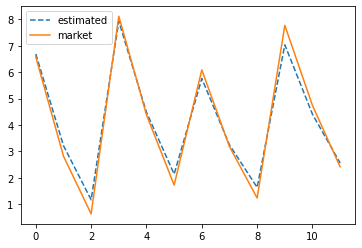

In [107]:
def analyze_calibration_result(real_value):
    estimated_value_all = np.array([])

    for i, experiments_result in enumerate(experiments_result_best):
        params = experiments_result['params']
        c_estimated, c_sd, mae = calibrate_hw_model(params['alpha'], params['rho'], params['theta'],params['epsilon'])
        glog.info(f"Current Round: {i}, MAE {mae}")

        if i == 0:
            estimated_value_all = c_estimated
        else:
            estimated_value_all = np.vstack([estimated_value_all, c_estimated])

    estimated_value = estimated_value_all.mean(axis=0)
    mse = mean_squared_error(real_value, estimated_value)
    r2 = r2_score(real_value, estimated_value)
    mae = mean_absolute_error(real_value, estimated_value)
    performance_table = pd.DataFrame([[mae, mse, r2]], index=['Metric'], columns=['MAE', 'MSE', 'R^2']).T

    print(performance_table)
    plt.plot(estimated_value, '--', label='estimated')
    plt.plot(real_value,  label='market')
    plt.legend()
    plt.show()

    return  performance_table

# c_estimated, c_sd, mae = calibrate_hw_model(experiments_result_best[0]['params']['alpha'], experiments_result_best[0]['params']['phi'], experiments_result_best[0]['params']['rho'])
calibration_performance_table = analyze_calibration_result(market_info['c'])

### Pricing and averaging 100 models

In [108]:
# run monte carlo simulation to pricing

def run_price_engine(option_type):
    print(f"option_type {option_type}")
    pricing_results = deepcopy(experiments_result_best)

    for i, experiments_result in enumerate(experiments_result_best):
        params = experiments_result['params']

        option_info = {
            "s_0": market_info['S0'],
            "r": market_info['r'],
            "v_0": market_info['v_0'],
            "alpha": params['alpha'], #-0.12164181303597861,
            #"phi": params['phi'], #0.20753635960129074,
            "rho": params['rho'], #0.5475203500687003,
            "K": 100,     # K= 95, 100, 105
            "V": 0.17,    # strike volatility
            "T": 1,
            "n": int(1e6),
            "time_steps": 12,
            'option_type': option_type,
            "entitle_ratio": int(2e7),
            "drawdown_threshold": 0.1,
            "vol_threshold": 0.17,
            "theta": params['theta'],
            "epsilon": params['epsilon']
        }
        mce = MonteCarloEngineHullWhite(option_info)
        mean, stderr = mce.run_mc_engine()
        pricing_results[i]['price_mean'] = mean
        pricing_results[i]['stderr'] = stderr

        glog.info(f"Current Round: {i} Estimate Price per 1 percent of vol, mean: {mean}, option stderr {stderr}")
    return pricing_results

In [109]:
pricing_results_vanilla = run_price_engine("vanilla")
# joblib.dump(pricing_results_vanilla, "./results/pricing_results_vanilla_v1.pkl")

option_type vanilla


I0608 17:28:03.520579 53308 3461529180.py:34] Current Round: 0 Estimate Price per 1 percent of vol, mean: 33661767.49793787, option stderr 132703.83898609036
I0608 17:28:06.241299 53308 3461529180.py:34] Current Round: 1 Estimate Price per 1 percent of vol, mean: 38265820.32112456, option stderr 142015.76829841617
I0608 17:28:08.967856 53308 3461529180.py:34] Current Round: 2 Estimate Price per 1 percent of vol, mean: 39996161.4186102, option stderr 145748.98784613915
I0608 17:28:11.706163 53308 3461529180.py:34] Current Round: 3 Estimate Price per 1 percent of vol, mean: 32379023.116136793, option stderr 141452.90045447098
I0608 17:28:14.512890 53308 3461529180.py:34] Current Round: 4 Estimate Price per 1 percent of vol, mean: 7738867.140319239, option stderr 43749.33212384846
I0608 17:28:17.352146 53308 3461529180.py:34] Current Round: 5 Estimate Price per 1 percent of vol, mean: 8699759.63336453, option stderr 51768.98006855418
W0608 17:28:18.914943 53308 warnings.py:109] /var/folde

I0608 17:30:54.018100 53308 3461529180.py:34] Current Round: 52 Estimate Price per 1 percent of vol, mean: 2049106.2858264416, option stderr 19548.670339910306
I0608 17:30:57.397831 53308 3461529180.py:34] Current Round: 53 Estimate Price per 1 percent of vol, mean: 21461623.784048382, option stderr 97369.87507350514
I0608 17:31:01.001507 53308 3461529180.py:34] Current Round: 54 Estimate Price per 1 percent of vol, mean: 18376596.028693322, option stderr 82291.17793128305
I0608 17:31:04.319834 53308 3461529180.py:34] Current Round: 55 Estimate Price per 1 percent of vol, mean: 7440803.902016676, option stderr 43195.23582445814
I0608 17:31:07.701833 53308 3461529180.py:34] Current Round: 56 Estimate Price per 1 percent of vol, mean: 1918360.283193854, option stderr 18652.61797770748
I0608 17:31:11.135859 53308 3461529180.py:34] Current Round: 57 Estimate Price per 1 percent of vol, mean: 6894788.7081210045, option stderr 40442.65939379024
I0608 17:31:15.129145 53308 3461529180.py:34] C

         price_mean   price_stderr
count  9.100000e+01      91.000000
mean   1.610132e+07   76605.123180
std    1.504474e+07   56428.172629
min    9.649294e+05   12648.812912
25%    4.832216e+06   34278.388866
50%    1.042415e+07   52829.346073
75%    2.120203e+07  108811.377631
max    6.058988e+07  221348.085125


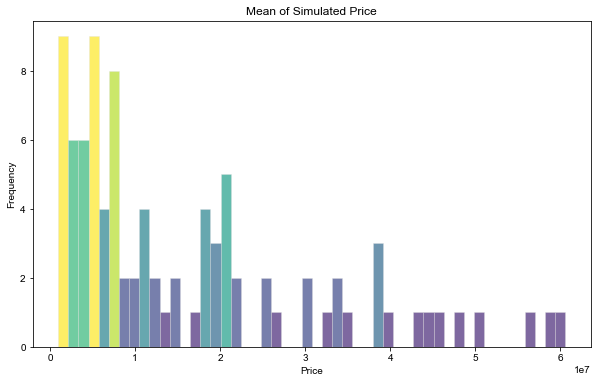

In [113]:
def analyze_pricing_result(pricing_results):
    price_mean_list = [result['price_mean'] for result in pricing_results]
    price_stderr_list = [result['stderr'] for result in pricing_results]
    df_result = pd.DataFrame([price_mean_list, price_stderr_list], index=['price_mean', 'price_stderr']).T
    df_summary = df_result.describe()
    df_summary.to_csv(f"./results/pricing_summary.csv")
    # summary tabel
    print(df_summary)

    # plot
    plt.figure(figsize=(10,6))
    plt.title('Mean of Simulated Price', fontsize=12)
    plt.xlabel('Price', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.style.use('seaborn-whitegrid')
    n, bins, patches = plt.hist(price_mean_list, bins=50, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
    for i in range(len(patches)):
        patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
    plt.show()

analyze_pricing_result(pricing_results_vanilla)

In [114]:
mce = MonteCarloEngineHullWhite(option_info)
mean, stderr = mce.run_mc_engine()
print(f"Estimate Price per 1 percent of vol, mean: {mean}, option stderr {stderr}")
print(f"Estimate Price per 1 unit of vol, mean: {mean*100}, option stderr {stderr*100}")

W0608 17:43:57.207241 53308 warnings.py:109] /var/folders/52/w96pnmj15psfl60mpn_hc7kh0000gn/T/ipykernel_53308/2947812241.py:110: RuntimeWarning: invalid value encountered in log
  stock_return = np.log(self.stock_price_paths[1:,:] / self.stock_price_paths[:-1,:])



Estimate Price per 1 percent of vol, mean: nan, option stderr nan
Estimate Price per 1 unit of vol, mean: nan, option stderr nan


In [115]:
mce.analyze_simulated_results()

W0608 17:44:00.998522 53308 warnings.py:109] /var/folders/52/w96pnmj15psfl60mpn_hc7kh0000gn/T/ipykernel_53308/2947812241.py:144: RuntimeWarning: invalid value encountered in sqrt
  vol_last = self.variance_paths[-1,:] ** 0.5

W0608 17:44:01.129658 53308 warnings.py:109] /var/folders/52/w96pnmj15psfl60mpn_hc7kh0000gn/T/ipykernel_53308/2947812241.py:152: RuntimeWarning: invalid value encountered in log
  stock_return = np.log(self.stock_price_paths[1:, :] / self.stock_price_paths[:-1, :])



,mean,stdv
simulated_volatility,NaN,NaN
realized_volatility,NaN,NaN
stock_price,103.876716,14.647138
